# Model

This model is build to work with data from multiple datasets that have been processed to 112x112 size.

## Imports and information

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
from functools import partial
from random import randint

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
## WWMR data paths
wwmr_X_fp = r'D:\data\face_mask\WWMR cropped MediaPipe\WWMR_X_for_model.npy'
wwmr_y_fp = r'D:\data\face_mask\WWMR cropped MediaPipe\WWMR_y_for_model.npy'

## Build data loader

In [3]:
class maskDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
        norm_0_1: bool = True,
        print_stats: bool = True,
    ):        
        self.X_data = X_data
        
        # Norm
        if norm_0_1:
            self.X = self.X_data / 255
        else:
            self.X = self.X_data
        
        self.y = y_data
        
        self.length = len(self.y)
        
        # Print Stats
        if print_stats:
            print('# examples:    {}'.format(self.length))
            ratio = sum(self.y) / self.length
            print('class balence: {:.2f}'.format(ratio))

        # reshape?? see comment in __getitem__() ?????
        self.X = self.X.reshape((self.length, 3, 112, 112)) 
        
    def __len__(self):
        return self.length
    
   
    def __getitem__(self, index):
        image = self.X[index]
        
        # the input to a conv2d must be in [N, C, W, H] format
        #  n = number of examples, c is channels, w is width, and h is height
        #  This means we do not in fact need to transpose the data. it should
        #  be in the shape (3, 112, 112)
        #image = np.transpose(image)
        #image = np.rot90(image, k=3)
        
        return image.astype(np.float32), torch.tensor(self.y[index]).long()    

In [4]:
# function to concat the various data sets and split into train val test

def merge_split(
    X_data_lists: list,
    y_data_lists: list,
    train=0.7,
    val=0.15,
    test=0.15
):
    if (train + val + test) != 1:
        print('splits must add to 1, added to {}'.format(train + val + test))
        return None
    if train < 0 or val < 0 or test < 0:
        print('splits must be positive')
        return None

    # Concat
    X = np.concatenate(X_data_lists)
    y = np.concatenate(y_data_lists)
    
    # split off test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test, random_state=42)
    
    # split off val
    val_percent_tv = val / (val + train)  # 15 percent of total data is equal to this
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_percent_tv, random_state=42)
    
    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

### Test data loader

In [6]:
# data file paths
X_fp_list = [wwmr_X_fp]
y_fp_list = [wwmr_y_fp]

X_data_list = [np.load(fp) for fp in X_fp_list]
y_data_list = [np.load(fp) for fp in y_fp_list]

In [7]:
# merge data and split into train val and test
(X_train, y_train), (X_val, y_val), (X_test, y_test) = merge_split(X_data_list, y_data_list)

In [8]:
ds = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=True,
)

# examples:    392
class balence: 0.26


In [9]:
ds.X.shape

(392, 3, 112, 112)

In [10]:
ds[2][0].shape

(3, 112, 112)

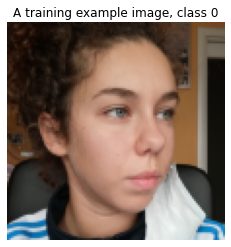

In [12]:
img_idx = randint(0, 300)

image, label = ds[img_idx]

# un-normalize
image = (image * 255).astype(np.uint8)

# show image
plt.imshow(image.reshape(112, 112, 3))
plt.title('A training example image, class {}'.format(label) )
plt.axis('off')
plt.show()

## Model

The following model is implemented in pytorch. It uses several convotutional layers followed by several linear layers.

In [20]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size: Sequence[int] = (3, 112, 112),
        num_classes: int = 2,
        channels: Sequence[int] = (8, 16, 32),
        kernel_sizes: Sequence[int] = (10, 10, 10, 10),
        linear_units: Sequence[int] = (100, 10),
    ):
        super(CNN, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.channels = input_size[0:1] + channels
        self.kernel_sizes = kernel_sizes
        self.linear_units = linear_units
        
        self.flatten = nn.Flatten()
        self.pool = partial(nn.MaxPool2d, kernel_size=2, stride=2)  # first 2 is for 2x2 kernel, second is stride length
        self.dropout = nn.Dropout
        self.activation = nn.ReLU
        self.accuracy = torchmetrics.functional.accuracy
        self.conf_matrix = torchmetrics.functional.confusion_matrix
        
        # optional, define batch norm here
        
        # build the convolutional layers
        conv_layers = list()
        for in_channels, out_channels, kernel_size in zip(
            self.channels[:-2], self.channels[1:-1], self.kernel_sizes[:-1]
        ):
            conv_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    #stride=2,
                    #padding='same',
                )
            )
            conv_layers.append(self.activation())
            conv_layers.append(self.pool())
        # add final layer to convolutions
        conv_layers.append(
            nn.Conv2d(
                in_channels=self.channels[-2],
                out_channels=self.channels[-1],
                kernel_size=self.kernel_sizes[-1],
                stride=2,
                #padding='same',
            )
        )
        conv_layers.append(self.activation())
        conv_layers.append(self.pool())

        
        # turn list into layers
        self.conv_net = nn.Sequential(*conv_layers)
        
        # linear layers
        linear_layers = list()
        prev_linear_size = self.channels[-1] * 9  # const scale it correctly
        for dense_layer_size in self.linear_units:
            linear_layers.append(
                nn.Linear(
                    in_features=prev_linear_size,
                    out_features=dense_layer_size,
                )
            )
            linear_layers.append(self.activation())
            prev_linear_size=dense_layer_size
            
        self.penultimate_dense = nn.Sequential(*linear_layers)
        self.ultimate_dense = nn.Linear(
            in_features=self.linear_units[-1],
            out_features=self.num_classes
        )
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_net(x)
        x = self.flatten(x)
        # may need to expand dense entry since flatten
        x = self.penultimate_dense(x)
        x = self.ultimate_dense(x)
        return x


def train(dataloader, model, loss_fn, optimizer, verbose=False):
    #model = model.float()  # sometime fixes random obscure type error
    model.train()  # configures for training, grad on, dropout if there is dropout
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # compute prediction loss
        preds = model(X)
        loss = loss_fn(preds, y)
        
        # backprop
        loss.backward()
        optimizer.step()
        
        if batch % 5 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# for evaluating on validation data too
def test(dataloader, model, loss_fn, verbose=False):
    model.eval()
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:

            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss
        

The below 2 blocks show the structure of the model with the default parameters for the convolution sizes, convolution kernel sizes, and linear layer sizes.

In [14]:
net = CNN()

In [15]:
net

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(10, 10), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU()
  )
  (ultimate_dense): Linear(in_features=10, out_features=2, bias=True)
)

## Running the model

Running the pytorch model involves several steps. First, the pytorch datasets must be set up. They take in the X and y data at construction to become an object that can serve up the data on command. Next, the pytorch data loaders are created. These data loaders are another pytorch object which takes in the dataset, whether to shuffle or not, and the batch size.

The model, loss function, and optimizer are created next. The training loop follows. This loop runs the training loop defined above with the model and then evaluates on the validation data.

In [16]:
# Create datasets
train_dataset = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=False,
)

val_dataset = maskDataset(
    X_data=X_val,
    y_data=y_val,
    norm_0_1=True,
    print_stats=False,
)

test_dataset = maskDataset(
    X_data=X_test,
    y_data=y_test,
    norm_0_1=True,
    print_stats=False,
)

In [17]:
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create CNN
model = CNN()

# use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.003,
    momentum=0.9,
    #nesterov =True
    weight_decay =.0001
)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# record results
train_loss = []
val_loss = []
val_accur = []

epochs = 25
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 

Using cpu device
Results: 
 Accuracy: 20.2%, Avg loss: 0.740256 

Results: 
 Accuracy: 20.2%, Avg loss: 0.726783 

Results: 
 Accuracy: 20.2%, Avg loss: 0.709679 

Results: 
 Accuracy: 79.8%, Avg loss: 0.689264 

Results: 
 Accuracy: 79.8%, Avg loss: 0.671116 

Results: 
 Accuracy: 79.8%, Avg loss: 0.653438 

Results: 
 Accuracy: 79.8%, Avg loss: 0.635763 

Results: 
 Accuracy: 79.8%, Avg loss: 0.619947 

Results: 
 Accuracy: 79.8%, Avg loss: 0.606278 

Results: 
 Accuracy: 79.8%, Avg loss: 0.592417 

Results: 
 Accuracy: 79.8%, Avg loss: 0.579037 

Results: 
 Accuracy: 79.8%, Avg loss: 0.565280 

Results: 
 Accuracy: 79.8%, Avg loss: 0.554217 

Results: 
 Accuracy: 79.8%, Avg loss: 0.540636 

Results: 
 Accuracy: 79.8%, Avg loss: 0.527817 

Results: 
 Accuracy: 79.8%, Avg loss: 0.513102 

Results: 
 Accuracy: 79.8%, Avg loss: 0.504687 

Results: 
 Accuracy: 79.8%, Avg loss: 0.505332 

Results: 
 Accuracy: 79.8%, Avg loss: 0.504147 

Results: 
 Accuracy: 79.8%, Avg loss: 0.510413 

Res

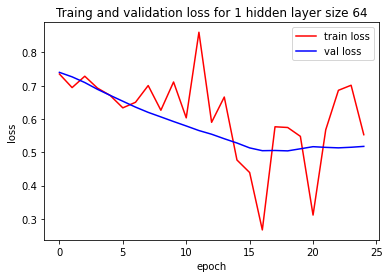

In [18]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss for 1 hidden layer size 64')
plt.show()

In [19]:
# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in val_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        67
           1       0.00      0.00      0.00        17

    accuracy                           0.80        84
   macro avg       0.40      0.50      0.44        84
weighted avg       0.64      0.80      0.71        84



C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the current parameters, we get an accuracy of 95.7% on the validation data and an f1 score of 0.97.

### Optimizer param sweep

Takes ~6 hours, depending on system specs highly. The results are saved.

In [30]:

# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

lrs = [.005, .01]
decays = [.0001, .0005, .001]
channels = [(16, 24, 32), (8, 16, 32)] 
linear_units = [ (100, 10), (100, 50, 10)]

lr_list = []
deacy_list = []
max_val_acc_list = []
at_epoch_list = []
channel_list = []
linear_units_list = []

counter = 0

for lr in lrs:
    for decay in decays:
        for channel in channels:
            for linear_unit in linear_units:

                max_val_acc = 0
                best_epoch = 0

                # Create CNN
                model = CNN(
                    channels=channel,
                    #kernel_sizes=kernel_size,
                    linear_units=linear_unit,
                )

                # use cross entropy loss
                loss_fn = nn.CrossEntropyLoss()

                # SGD optimizer
                optimizer = torch.optim.SGD(
                    model.parameters(), 
                    lr=lr,
                    momentum=0.9,
                    #nesterov =True
                    weight_decay=decay
                )
                #optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


                # record results
                train_loss = []
                val_loss = []
                val_accur = []

                epochs = 25
                for t in range(epochs):
                    #print(f"Epoch {t+1}\n-------------------------------")

                    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
                    train_loss.append(train_l)

                    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=False)
                    val_loss.append(val_l)
                    val_accur.append(val_a) 

                    if val_a > max_val_acc:
                        max_val_acc = val_a
                        best_epoch = t


                lr_list.append(lr)
                deacy_list.append(decay)
                max_val_acc_list.append(max_val_acc)
                at_epoch_list.append(best_epoch)
                channel_list.append(channel)
                linear_units_list.append(linear_unit)
                
                counter += 1
            print('kernel choice')
        print('finished config {}'.format(counter))
    print('finished lr {}'.format(lr))

print()
    

Using cpu device
kernel choice
kernel choice
finished config 4
kernel choice
kernel choice
finished config 8
kernel choice
kernel choice
finished config 12
finished lr 0.005
kernel choice
kernel choice
finished config 16
kernel choice
kernel choice
finished config 20
kernel choice
kernel choice
finished config 24
finished lr 0.01



In [31]:

results = pd.DataFrame(
    data={
        'lr': lr_list,
        'decay': deacy_list,
        'val acc': max_val_acc_list,
        'at epoch': at_epoch_list,
        'channels': channel_list,
        'linear units': linear_units_list
    }
)

#print()

In [32]:
results.sort_values(by='val acc', ascending=False)

,lr,decay,val acc,at epoch,channels,linear units
0,0.005,0.0001,0.797619,0,"(16, 24, 32)","(100, 10)"
1,0.005,0.0001,0.797619,0,"(16, 24, 32)","(100, 50, 10)"
22,0.010,0.0010,0.797619,0,"(8, 16, 32)","(100, 10)"
21,0.010,0.0010,0.797619,0,"(16, 24, 32)","(100, 50, 10)"
20,0.010,0.0010,0.797619,0,"(16, 24, 32)","(100, 10)"
19,0.010,0.0005,0.797619,0,"(8, 16, 32)","(100, 50, 10)"
18,0.010,0.0005,0.797619,1,"(8, 16, 32)","(100, 10)"
17,0.010,0.0005,0.797619,0,"(16, 24, 32)","(100, 50, 10)"
16,0.010,0.0005,0.797619,2,"(16, 24, 32)","(100, 10)"
15,0.010,0.0001,0.797619,0,"(8, 16, 32)","(100, 50, 10)"


In [33]:
results.to_pickle('./results/wwmr_param_search.pickle')

In [34]:
# load results
results = pd.read_pickle('./results/wwmr_param_search.pickle')
sorted_results = results.sort_values(by='val acc', ascending=False)
sorted_results.head(7)

,lr,decay,val acc,at epoch,channels,linear units
0,0.005,0.0001,0.797619,0,"(16, 24, 32)","(100, 10)"
1,0.005,0.0001,0.797619,0,"(16, 24, 32)","(100, 50, 10)"
22,0.010,0.0010,0.797619,0,"(8, 16, 32)","(100, 10)"
21,0.010,0.0010,0.797619,0,"(16, 24, 32)","(100, 50, 10)"
20,0.010,0.0010,0.797619,0,"(16, 24, 32)","(100, 10)"
19,0.010,0.0005,0.797619,0,"(8, 16, 32)","(100, 50, 10)"
18,0.010,0.0005,0.797619,1,"(8, 16, 32)","(100, 10)"


This sweep tells us that a lr of .005 and a decay of 0.0005 gives the best validation accuracy of 98% at epoch 38. Given such great accuracy (far above naive accuarcy obtained by guessing most frequent class), I don't think an architecture search will be nessisary. More specifically, it is lower priority than other tasks.

### Training an optimized model

In [35]:
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



max_val_acc = 0
best_epoch = 0

# Create CNN Model
model = CNN(
    #channels = (8, 16, 16),  #changed
    #kernel_sizes = (10, 10, 10, 10),
    linear_units = (100, 50, 10),
)

# use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.005,
    momentum=0.9,
    #nesterov =True
    weight_decay=0.0005
)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# record results
train_loss = []
val_loss = []
val_accur = []


epochs = 4
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")

    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l)

    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=False)
    val_loss.append(val_l)
    val_accur.append(val_a) 

    if val_a > max_val_acc:
        max_val_acc = val_a
        best_epoch = t

Using cpu device


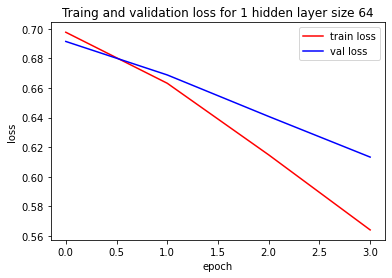

In [36]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss for 1 hidden layer size 64')
plt.show()

In [37]:
# get val predictions and true labels for a classification report
preds = []
y_true = []

model.eval()
with torch.no_grad():
    for X, y in val_dataloader:
        pred = model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        67
           1       0.00      0.00      0.00        17

    accuracy                           0.80        84
   macro avg       0.40      0.50      0.44        84
weighted avg       0.64      0.80      0.71        84



C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\envs\DMProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
val_a, val_l = test(val_dataloader, model, loss_fn, verbose=False)
print('validation accuracy: {:.2%}'.format(val_a))

validation accuracy: 79.76%


The variance in this value is due to the stochastic nature of pytorch in how I've implemented the model. This result deviated from results in the sweep by just a little, which is no cause for alarm.


### Saving the model weights

To reuse the model, we will save the weights. Pytorch offers a very easy way to save model weights. The model itself will be placed into a python file so it can be imported.

In [39]:
weights_fp = './results/torch_model_weights_WWMR_only'
torch.save(model.state_dict(), weights_fp)